# COMPAS Bias and Accuracy

------------------------------------------------------
- Wiley Winters
- MSDS 640&nbsp;&mdash;&nbsp;Case Study
- 2025-AUG-24

----------------------------------------------------------------------------
Is there real bias in judicial decision-support software?  I will also explore whether this bias was intentional or not.  The software package this study will concentrate on is COMPAS by Equivant, but the research indicates that bias has been introduced into other software, and it is not just a COMPAS issue.  Furthermore, studies are conflicted with determining bias in judicial decision support systems [Wikipedia, 2025](https://en.wikipedia.org/wiki/COMPAS_(software)).</p>
A study conducted by [Ho et al. (2024)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4533047) determined that judicial decision support tools have a significant impact on a judge's decision-making process and while these tools are advertised as being objective, there are studies that indicate racial biases may have been introduced into the algorithms used by these tools that favor white offenders over non-white ones.  This analysis looks to confirm of disprove this assertion.  A study conducted by [ProPublica (2016)](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing)&nbsp;stated that COMPAS is round 68% accurate when predicting recidivism.

---------------------------------------------------
## Import Required Libraries and Packages

In [1]:
# Common Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import random, datetime

# Data Cleaning and Preprocessing
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Models
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

# Model Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve

# Special Plotting
from matplotlib import rcParams, pyplot

# Statistical Analysis
from scipy import stats

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set seaborn style and autoconfig
sns.set_style('whitegrid')
rcParams.update({'figure.autolayout': True})

# Set random seed
random.seed(42)

## Declare Functions

**Calculate Rates for Classification Model Performance Evaluation**&nbsp;&nbsp;The *True Positive Rate (TPR)*, *True Negative Rate (TNR)*, *False Positive Rate (FPR)*, and *False Negative Rate (FNR)* are tools used to measure how well a model classifies the classes being predicted.

In [2]:
# Calculate TPR, TNR, FPR, and FNR
def calc_rates(cm):
    tn, fp, fn, tp = cm.flatten()

    # TPR = TP / (TP + FN)
    tpr = tp / (tp +fn)
    # TNR = TN / (TN + TP)
    tnr = tn / (tn + tp)
    # FPR = FP / (FP + TN)
    fpr = fp / (fp + tn)
    # FNR = FN / (FN + TP)
    fnr = fn / (fn + tp)
    
    return tpr, tnr, fpr, fnr

**Common Scoring for Classification Models**&nbsp;&nbsp;I will be evaluating more than one model.  This function will provide a common scoring mechanism for them them.

In [3]:
# Score model
def score_model(model, X_train, X_test, y_train, y_test):
    my_model = model
    my_model = my_model.fit(X_train, y_train)
    prediction = my_model.predict(X_test)
    train_score = my_model.score(X_train, y_train)
    accur_score = accuracy_score(y_test, prediction)
    report = classification_report(y_test, prediction)
    cm = confusion_matrix(y_test, prediction)
    tpr, tnr, fpr, fnr = calc_rates(cm)
    
    print(f'Model:          {my_model}')
    print(report)
    print(f'Train Score:    {train_score:.2f}')
    print(f'Accuracy Score: {accur_score:.2f}')
    print(f'TPR Rate:       {tpr:.2f}')
    print(f'TNR Rate:       {tnr:.2f}')
    print(f'FPR Rate:       {fpr:.2f}')
    print(f'FNR Rate:       {fnr:.2f}')
    
    return prediction, cm

## Read Dataset
In 2016 ProPublic conducted a study to identify racial bias in the COMPAS algorithm.  Part of the study examined a two-year follow-up dataset to determine if individuals actually committed crimes or violent offenses during that period.  This study will use the same dataset, but will utilize a logistics regression model to classify the COMPAS risk scores with actual recidivism.  The relevant dataset from the ProPublica repository is being loaded and analyzed.  Repository can be found [here](https://github.com/propublica/compas-analysis)</p>
For this study, I selected the `compas-scores-two-years.csv` file.  It contains the original risk score from COMPAS plus a flag that indicates if recidivism was committed by the defendant.

In [4]:
compas_df = pd.read_csv('data/compas-scores-two-years.csv')
compas_df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


## Perform general EDA on the DataFrame

In [5]:
display(compas_df.shape)
display(compas_df.info())

(7214, 53)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  priors_count            

None

In [6]:
compas_df.isna().sum()

id                            0
name                          0
first                         0
last                          0
compas_screening_date         0
sex                           0
dob                           0
age                           0
age_cat                       0
race                          0
juv_fel_count                 0
decile_score                  0
juv_misd_count                0
juv_other_count               0
priors_count                  0
days_b_screening_arrest     307
c_jail_in                   307
c_jail_out                  307
c_case_number                22
c_offense_date             1159
c_arrest_date              6077
c_days_from_compas           22
c_charge_degree               0
c_charge_desc                29
is_recid                      0
r_case_number              3743
r_charge_degree            3743
r_days_from_arrest         4898
r_offense_date             3743
r_charge_desc              3801
r_jail_in                  4898
r_jail_o

## Data Cleaning

There are some columns that are missing a significant amount of data and others that are obviously not required for this study.  I will drop these

In [7]:
drop_cols = ['id','name','first','last','dob','age_cat','days_b_screening_arrest',
             'c_offense_date','c_arrest_date','r_case_number', 'r_charge_degree',
             'r_days_from_arrest','r_offense_date','r_charge_desc','r_jail_in',
             'r_jail_out','violent_recid','vr_case_number','vr_charge_degree',
             'vr_offense_date','vr_charge_desc','score_text','v_score_text',
             'c_case_number','c_charge_desc']
compas_df.drop(columns=drop_cols, inplace=True, errors='ignore')
compas_df.head()

,compas_screening_date,sex,age,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,c_jail_in,...,v_type_of_assessment,v_decile_score,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,2013-08-14,Male,69,Other,0,1,0,0,0,2013-08-13 06:03:42,...,Risk of Violence,1,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,2013-01-27,Male,34,African-American,0,3,0,0,0,2013-01-26 03:45:27,...,Risk of Violence,1,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,2013-04-14,Male,24,African-American,0,4,0,1,4,2013-04-13 04:58:34,...,Risk of Violence,3,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,2013-01-13,Male,23,African-American,0,8,1,0,1,NaN,...,Risk of Violence,6,2013-01-13,NaN,NaN,1,0,1174,0,0
4,2013-03-26,Male,43,Other,0,1,0,0,2,NaN,...,Risk of Violence,1,2013-03-26,NaN,NaN,2,0,1102,0,0


In [8]:
compas_df.shape

(7214, 28)

### Fix Data Types
There are some datetime columns that are being treated as objects.  I will fix those.

In [9]:
date_recs = ['c_jail_in','c_jail_out','compas_screening_date','v_screening_date',
             'in_custody','out_custody','screening_date']
for rec in date_recs:
    compas_df[rec] = pd.to_datetime(compas_df[rec])

### Handle missing values.

In [10]:
# Handel date columns
compas_df.c_jail_in = compas_df.c_jail_in.interpolate(method='linear')
compas_df.c_jail_out = compas_df.c_jail_out.interpolate(method='linear')
compas_df.v_screening_date = compas_df.v_screening_date.interpolate(method='linear')
compas_df.in_custody = compas_df.in_custody.interpolate(method='linear')
compas_df.out_custody = compas_df.out_custody.interpolate(method='linear')

# Handle numeric columns
num_cols = compas_df.select_dtypes(include=['int64','float64']).columns
non_num_cols = compas_df.select_dtypes(exclude=['int64','float64']).columns

# Create imputer object
imputer = KNNImputer(n_neighbors=2)

# Impute data.  The KNNImputer returns a series that has to be converted back to a DataFrame
imputed_data = imputer.fit_transform(compas_df[num_cols])
imputed_df = pd.DataFrame(imputed_data, columns=num_cols)

# Concatenate numeric and non-numeric DataFrames
compas_df = pd.concat([imputed_df, compas_df[non_num_cols]], axis=1)
compas_df.isna().sum()

age                      0
juv_fel_count            0
decile_score             0
juv_misd_count           0
juv_other_count          0
priors_count             0
c_days_from_compas       0
is_recid                 0
is_violent_recid         0
decile_score.1           0
v_decile_score           0
priors_count.1           0
start                    0
end                      0
event                    0
two_year_recid           0
compas_screening_date    0
sex                      0
race                     0
c_jail_in                0
c_jail_out               0
c_charge_degree          0
type_of_assessment       0
screening_date           0
v_type_of_assessment     0
v_screening_date         0
in_custody               0
out_custody              0
dtype: int64

**NOTE** According to the ProPublica article a *decile_score* of -1 means they researchers could not find any COMPAS data on the individual.  I can drop these rows.

In [11]:
compas_df = compas_df.drop(compas_df[compas_df.decile_score == -1].index)
compas_df.decile_score.min()

np.float64(1.0)

## EDA (Basic)
Perform descriptive EDA to understand characteristics of that dataset

In [12]:
# Summary of descriptive statistics of dataset
compas_df.describe().T

,count,mean,min,25%,50%,75%,max,std
age,7214.0,34.817993,18.0,25.0,31.0,42.0,96.0,11.888922
juv_fel_count,7214.0,0.06723,0.0,0.0,0.0,0.0,20.0,0.473972
decile_score,7214.0,4.509565,1.0,2.0,4.0,7.0,10.0,2.856396
juv_misd_count,7214.0,0.090934,0.0,0.0,0.0,0.0,13.0,0.485239
juv_other_count,7214.0,0.109371,0.0,0.0,0.0,0.0,17.0,0.501586
priors_count,7214.0,3.472415,0.0,0.0,2.0,5.0,38.0,4.882538
c_days_from_compas,7214.0,57.767674,0.0,1.0,1.0,2.0,9485.0,329.419377
is_recid,7214.0,0.481148,0.0,0.0,0.0,1.0,1.0,0.499679
is_violent_recid,7214.0,0.113529,0.0,0.0,0.0,0.0,1.0,0.317261
decile_score.1,7214.0,4.509565,1.0,2.0,4.0,7.0,10.0,2.856396


In [13]:
display(compas_df['is_recid'].value_counts())
display(compas_df['is_violent_recid'].value_counts())
display(compas_df['two_year_recid'].value_counts())

is_recid
0.0    3743
1.0    3471
Name: count, dtype: int64

is_violent_recid
0.0    6395
1.0     819
Name: count, dtype: int64

two_year_recid
0.0    3963
1.0    3251
Name: count, dtype: int64

In [14]:
compas_df[['race','two_year_recid']].value_counts(normalize=True).mul(100).round(2)

race              two_year_recid
African-American  1.0               26.35
                  0.0               24.88
Caucasian         0.0               20.63
                  1.0               13.39
Hispanic          0.0                5.61
Other             0.0                3.38
Hispanic          1.0                3.22
Other             1.0                1.84
Asian             0.0                0.32
Native American   1.0                0.14
Asian             1.0                0.12
Native American   0.0                0.11
Name: proportion, dtype: float64

In [15]:
compas_df[['race','decile_score','two_year_recid']].value_counts(normalize=True).mul(100).round(2)

race              decile_score  two_year_recid
Caucasian         1.0           0.0               7.47
African-American  1.0           0.0               4.26
                  2.0           0.0               3.80
                  9.0           1.0               3.73
Caucasian         2.0           0.0               3.44
                                                  ... 
Native American   3.0           0.0               0.01
                  4.0           1.0               0.01
                  6.0           0.0               0.01
                                1.0               0.01
                  7.0           0.0               0.01
Name: proportion, Length: 103, dtype: float64

### Statistical Note
Some of the racial populations represented in this study are too small to be of value and may skew some of the statistical test that will be performed.  I will obtain the number of records for each group and exclude the ones that are under 32 rows.  According to my old Stats textbook (1990's) we should have at least 32 observations for the population to be useful.

In [16]:
groups = ['African-American','Asian','Caucasian','Hispanic','Other','Native American']
for group in groups:
    print(group)
    display(len(compas_df[compas_df['race'] == group]))

African-American


3696

Asian


32

Caucasian


2454

Hispanic


637

Other


377

Native American


18

The *Asian* and *Native American* groups are really underrepresented.  I will move them into the *Other* group.

In [17]:
compas_df.race.replace({'Asian':'Other','Native American':'Other'}, inplace=True)

**Outliers** Identify outliers

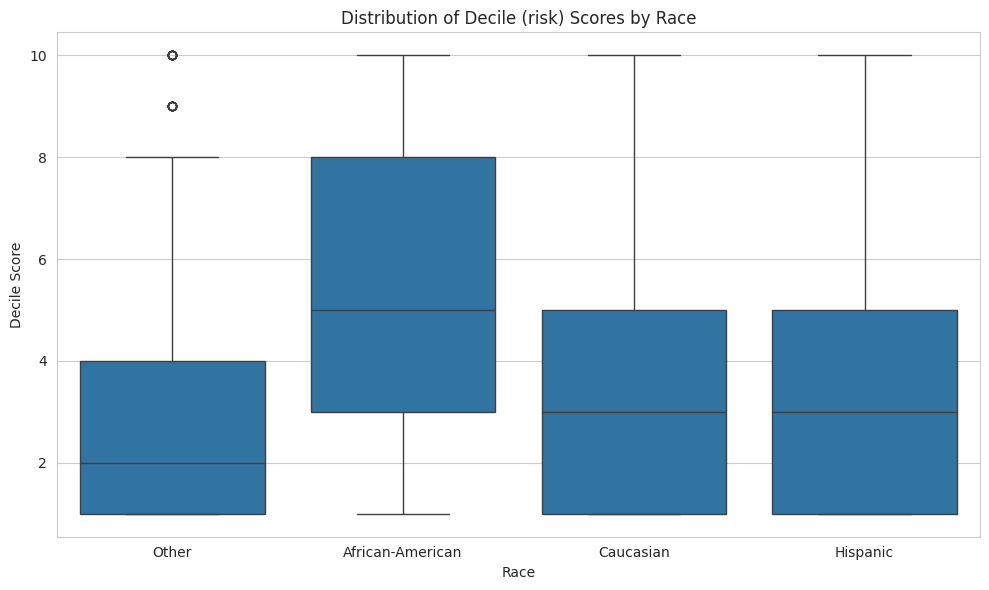

In [18]:
plt.figure(figsize=(10,6))
sns.boxplot(data=compas_df, x='race', y='decile_score')
plt.title('Distribution of Decile (risk) Scores by Race')
plt.xlabel('Race')
plt.ylabel('Decile Score')
plt.savefig('figures/boxplotDecileRace.png', bbox_inches='tight', dpi=300) 
plt.show()

At this time I am not concerned with the outliers identified in the `Other` group.

### Descriptive Plots

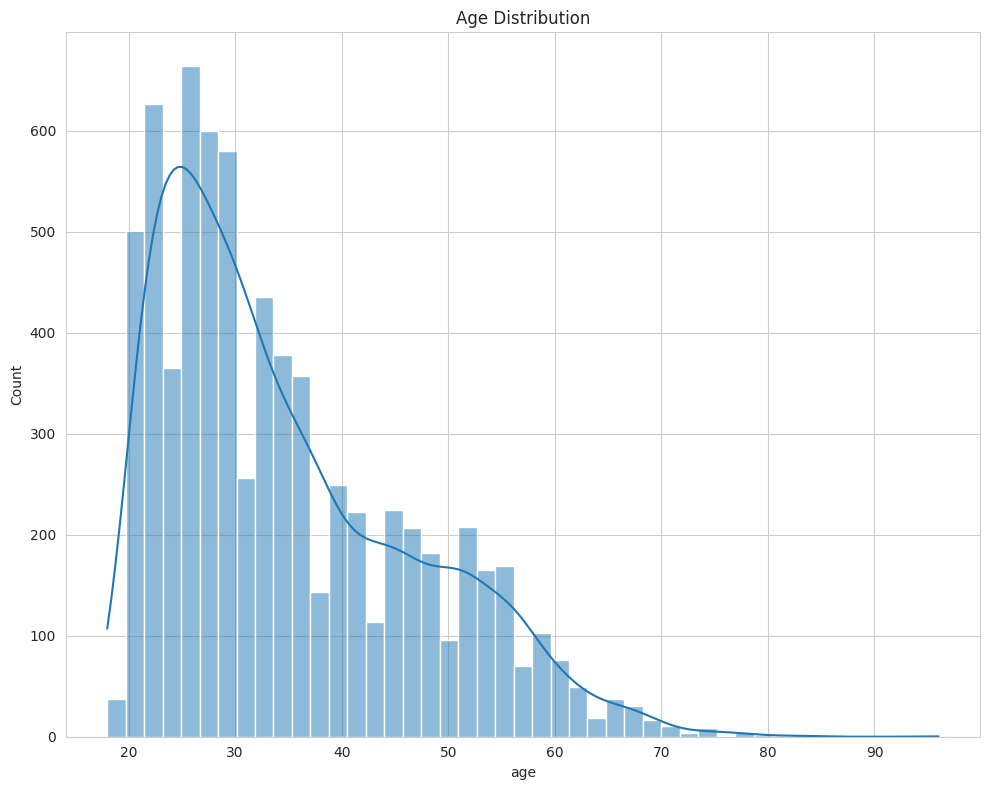

In [19]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set(xlabel='age', ylabel='Count', title='Age Distribution')
sns.histplot(compas_df, x='age', kde=True)
plt.tight_layout()
plt.show()
fig.savefig('./figures/ageDistribution.png', bbox_inches='tight', dpi=300)

In [20]:
compas_df['race'].value_counts(normalize=True).mul(100).sort_values(ascending=False)

race
African-American    51.233712
Caucasian           34.017189
Hispanic             8.830053
Other                5.919046
Name: proportion, dtype: float64

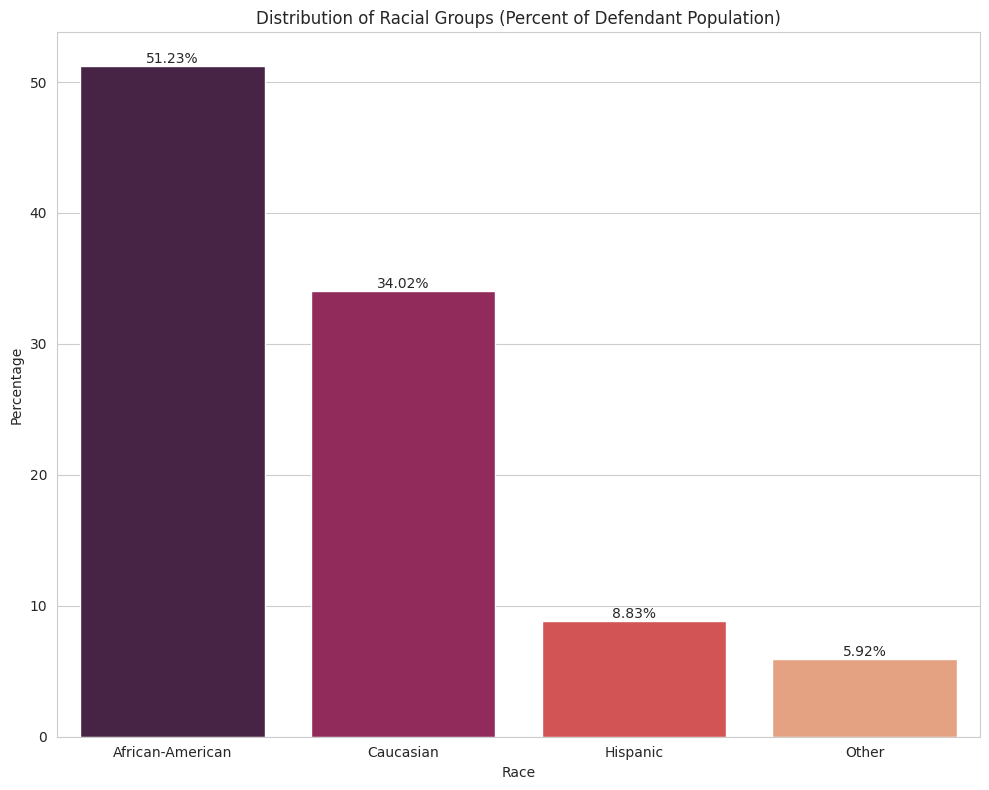

In [21]:
race_percentage = compas_df['race'].value_counts(normalize=True).mul(100).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(10,8))
ax.set(xlabel='Race', ylabel='Percentage', title='Distribution of Racial Groups (Percent of Defendant Population)')
sns.barplot(x=race_percentage.index, y=race_percentage.values, palette='rocket')
for container in ax.containers:
    ax.bar_label(container, fmt='{:,.2f}%')
plt.tight_layout()
plt.show()
fig.savefig('./figures/distributionRacialGroups.png', bbox_inches='tight', dpi=300)

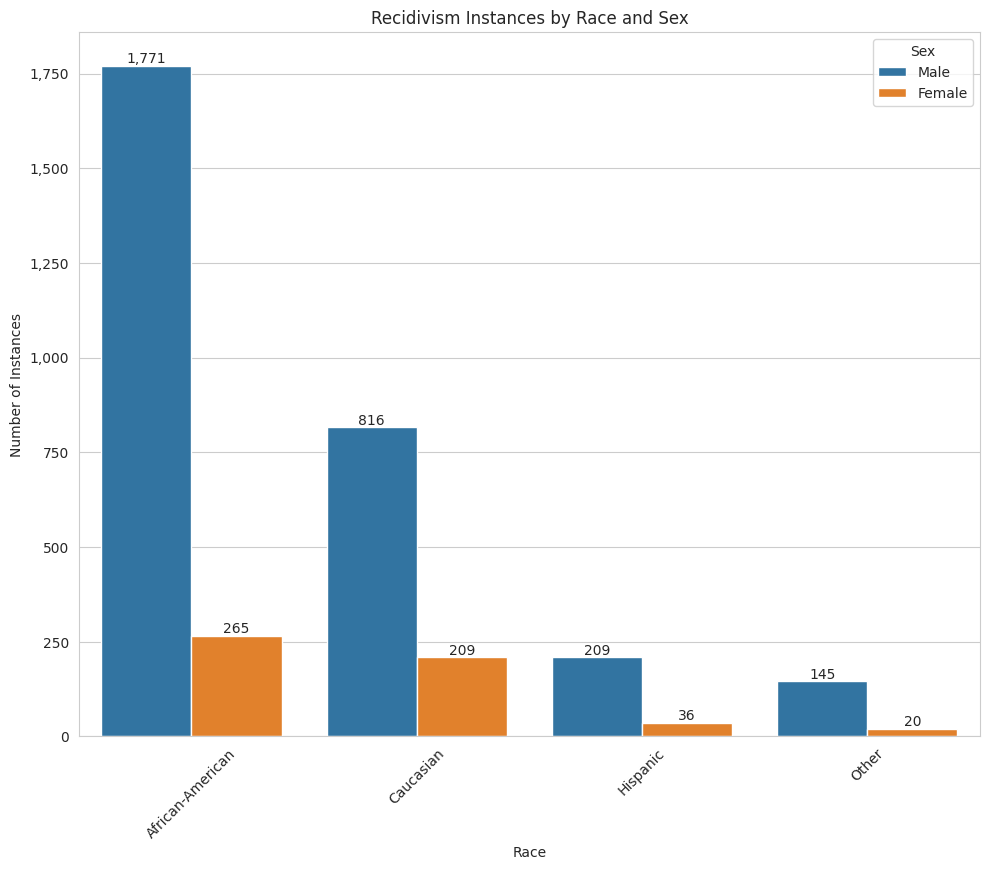

In [22]:
recivid = compas_df[compas_df['is_recid'] == 1]

fig, ax = plt.subplots(figsize=(10,8))
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
ax.set(xlabel='Race', ylabel='Number of Instances', title='Recidivism Instances by Race and Sex')
sns.countplot(recivid, x='race', hue='sex', hue_order=['Male','Female'])

for container in ax.containers:
    ax.bar_label(container, fmt='{:,.0f}')

plt.tight_layout()
plt.legend(title='Sex')
plt.xticks(rotation=45)
plt.show()
fig.savefig('./figures/recidivismByRaceSex.png', bbox_inches='tight', dpi=300)

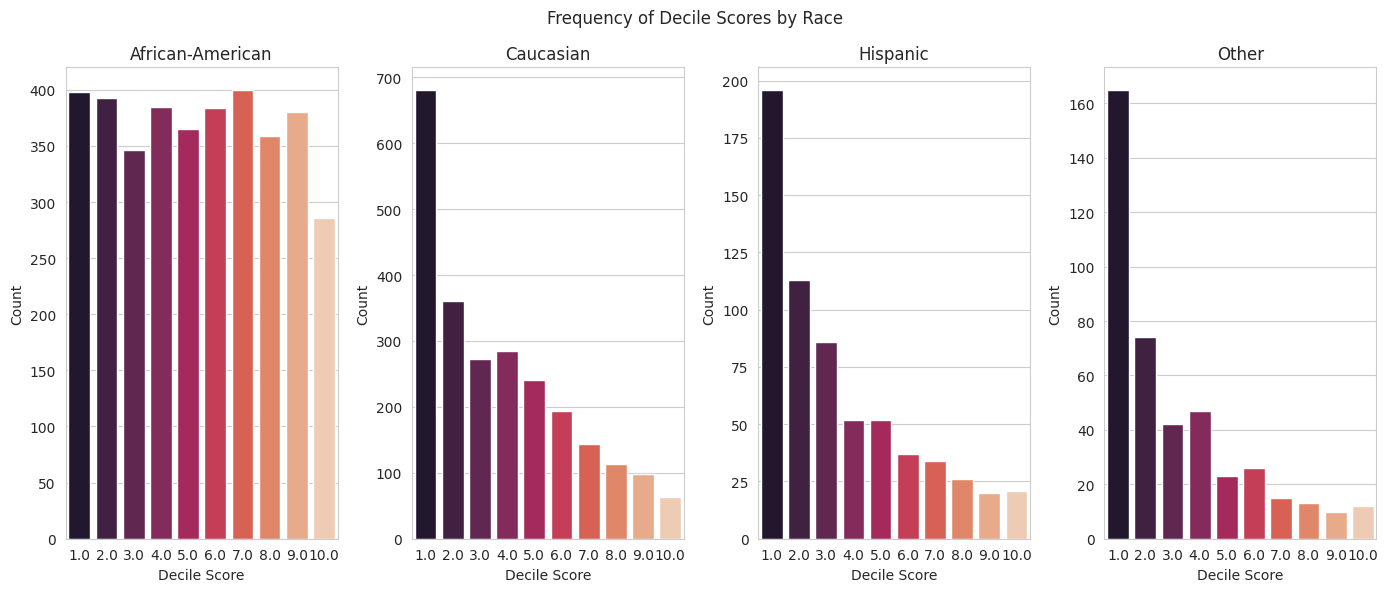

In [23]:
groups = ['African-American','Caucasian','Hispanic','Other']

fig, ax = plt.subplots(1, 4, figsize=(14,6))
ax = ax.flatten()

for i, race in enumerate(groups):
    race_data = compas_df[compas_df['race'] == race]
    sns.countplot(data=race_data, x='decile_score', ax=ax[i], palette='rocket')
    ax[i].set_title(race)
    ax[i].set_xlabel('Decile Score')
    ax[i].set_ylabel('Count')

fig.suptitle('Frequency of Decile Scores by Race')
plt.tight_layout()
plt.show()
fig.savefig('./figures/freqDecileByRace.png', bbox_inches='tight', dpi=300)

### ProPublica Note
According to the 2016 ProPublica article on COMPAS the plots below prove that COMPAS is biased against African Americans since they receive higher decile (risk) scores than the other racial groups.

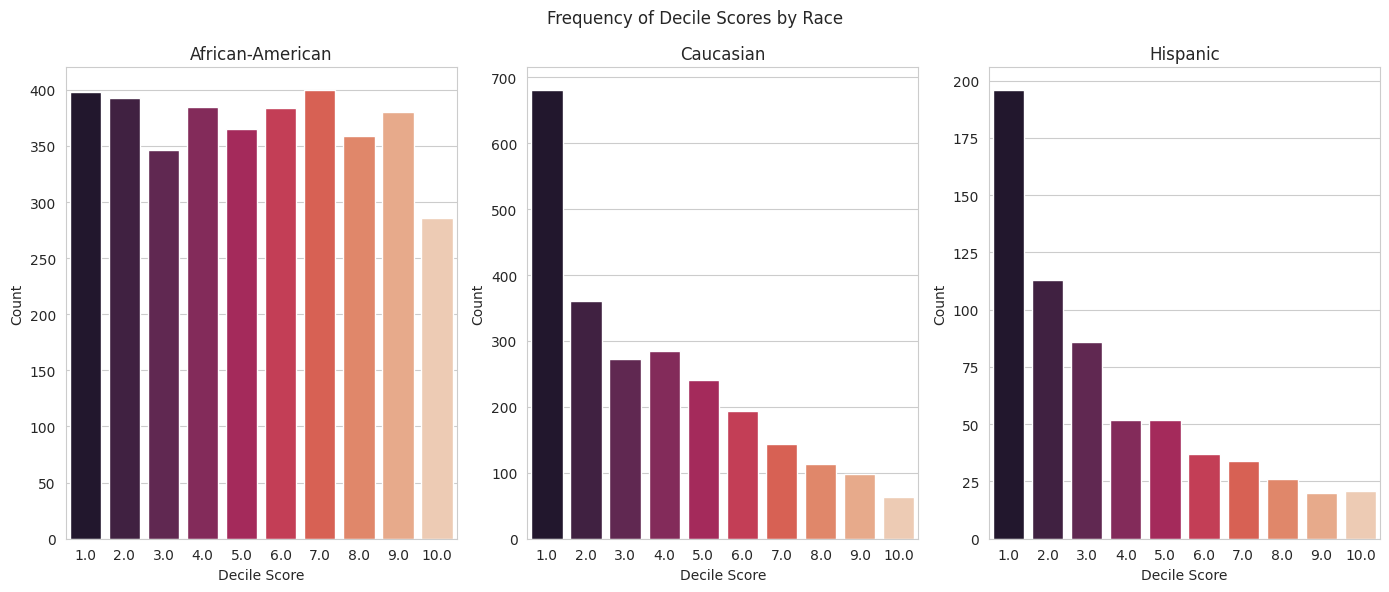

In [24]:
groups = ['African-American','Caucasian','Hispanic']

fig, ax = plt.subplots(1, 3, figsize=(14,6))
ax = ax.flatten()

for i, race in enumerate(groups):
    race_data = compas_df[compas_df['race'] == race]
    sns.countplot(data=race_data, x='decile_score', ax=ax[i], palette='rocket')
    ax[i].set_title(race)
    ax[i].set_xlabel('Decile Score')
    ax[i].set_ylabel('Count')

fig.suptitle('Frequency of Decile Scores by Race')
plt.tight_layout()
plt.show()
fig.savefig('./figures/freqDecileByRaceFiltered.png', bbox_inches='tight', dpi=300)

In [25]:
display(compas_df[(compas_df.race == 'African-American') & \
                  (compas_df.two_year_recid == 1)]['two_year_recid'].value_counts())
display(compas_df[(compas_df.race == 'Caucasian') & \
                  (compas_df.two_year_recid == 1)]['two_year_recid'].value_counts())

two_year_recid
1.0    1901
Name: count, dtype: int64

two_year_recid
1.0    966
Name: count, dtype: int64

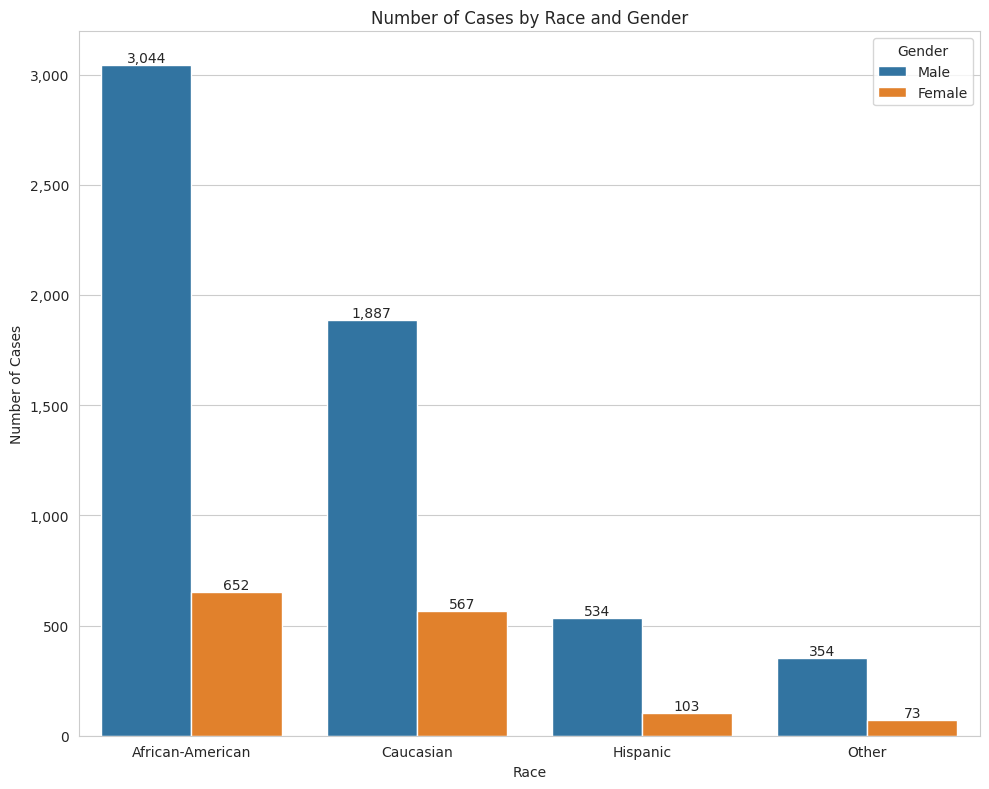

In [26]:
fig, ax = plt.subplots(figsize=(10,8))
order = ['African-American','Caucasian','Hispanic','Other']
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
ax.set(xlabel='Race', ylabel='Number of Cases', title='Number of Cases by Race and Gender')
sns.countplot(compas_df, x='race', hue='sex', order=order)

for container in ax.containers:
    ax.bar_label(container, fmt='{:,.0f}')
    
plt.legend(title='Gender')
plt.savefig('figures/caseRaceGender.png', bbox_inches='tight', dpi=300)
plt.show()

### Further Statistical Analysis

In [27]:
compas_df.groupby('race').agg({'decile_score': ['mean','std']}).reset_index()

race decile_score          
                            mean       std
0  African-American     5.368777  2.831122
1         Caucasian     3.735126  2.597926
2          Hispanic     3.463108  2.599100
3             Other     3.084309  2.478530

In [28]:
compas_df.groupby('race')['two_year_recid'].sum()

race
African-American    1901.0
Caucasian            966.0
Hispanic             232.0
Other                152.0
Name: two_year_recid, dtype: float64

**ANOVA**  The ProPublica 2016 article on COMPAS based its findings of bias on the number of high *decile_scores* assigned to African-Americans when compared to other groups.  The one_way ANOVA (***Analysis of Variance***) test is used to test if the mean of two or more *independent* groups are significantly different.  The *P-Value* of < 0.05 indicates the groups' means are significantly different; therefore, the null hypothesis is rejected and ProPublica's findings are verified.

In [29]:
# Normalize decile_score using Min-Max method
compas_df['normalized'] = compas_df.groupby('race')['decile_score']. \
          transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# group by race on the normalized value
groups = compas_df.groupby('race')['normalized'].apply(list)

# Perform the oneway ANOVA test
f_stat, p_val = stats.f_oneway(*groups)

# Print results
print('F-statistic: ',f_stat)
print('P-value:     ',p_val)
if p_val < 0.05:
    print('Null hypothesis is rejected')

F-statistic:  261.01168051564656
P-value:      8.089670291495388e-161
Null hypothesis is rejected


In [30]:
# Since the decile_score feature has been normalized
# into a new column, it is no longer required
compas_df.drop(columns=['decile_score'], axis=1, inplace=True)

In [31]:
# Get a list of datetime columns
date_cols = compas_df.select_dtypes(include=['datetime64']).columns
date_cols

Index(['compas_screening_date', 'c_jail_in', 'c_jail_out', 'screening_date',
       'v_screening_date', 'in_custody', 'out_custody'],
      dtype='object')

### Prepare DataFrame for Model Training

In [32]:
# Convert datetime fields to Unix epoch
compas_df['jail_in_epoch'] = compas_df.c_jail_in.astype(np.int64) // 10**9
compas_df['jail_out_epoch'] = compas_df.c_jail_out.astype(np.int64) // 10**9
compas_df['in_cust_epoch'] = compas_df.in_custody.astype(np.int64) // 10**9
compas_df['out_cust_epoch'] = compas_df.out_custody.astype(np.int64) // 10**9
compas_df['scn_date_epoch'] = compas_df.screening_date.astype(np.int64) // 10**9
compas_df['com_date_epoch'] = compas_df.compas_screening_date.astype(np.int64) // 10**9
compas_df['v_scn_date_epoch'] = compas_df.v_screening_date.astype(np.int64) // 10**9

In [33]:
compas_df[['jail_in_epoch','jail_out_epoch','in_cust_epoch','out_cust_epoch',
           'scn_date_epoch','com_date_epoch','v_scn_date_epoch']].sample(10)

,jail_in_epoch,jail_out_epoch,in_cust_epoch,out_cust_epoch,scn_date_epoch,com_date_epoch,v_scn_date_epoch
6261,1358069777,1358246484,1373500800,1401926400,1358121600,1358121600,1358121600
5837,1379142924,1379303232,1379116800,1379289600,1379203200,1379203200,1379203200
6856,1359445926,1359509781,1366588800,1367107200,1359504000,1359504000,1359504000
5134,1378292767,1378367681,1378252800,1378339200,1378339200,1378339200,1378339200
5274,1359349576,1359859843,1372464000,1392681600,1359331200,1359331200,1359331200
5906,1368063972,1368187814,1368057600,1368144000,1368057600,1368057600,1368057600
4808,1374234928,1377233002,1374192000,1377216000,1369440000,1369440000,1369440000
6092,1395400446,1395636504,1395360000,1395619200,1395446400,1395446400,1395446400
1640,1392192366,1392280196,1395878400,1396051200,1392249600,1392249600,1392249600
2103,1416557755,1416717516,1430265600,1434067200,1416614400,1416614400,1416614400


In [34]:
# Drop old date columns
compas_df.drop(columns=date_cols, axis=1, inplace=True, errors='ignore')

In [35]:
# Label encode sex, age_cat, and race
label_encoder = LabelEncoder()
compas_df.sex = label_encoder.fit_transform(compas_df.sex)
compas_df.race = label_encoder.fit_transform(compas_df.race)
compas_df.c_charge_degree = label_encoder.fit_transform(compas_df.c_charge_degree)

In [36]:
compas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   7214 non-null   float64
 1   juv_fel_count         7214 non-null   float64
 2   juv_misd_count        7214 non-null   float64
 3   juv_other_count       7214 non-null   float64
 4   priors_count          7214 non-null   float64
 5   c_days_from_compas    7214 non-null   float64
 6   is_recid              7214 non-null   float64
 7   is_violent_recid      7214 non-null   float64
 8   decile_score.1        7214 non-null   float64
 9   v_decile_score        7214 non-null   float64
 10  priors_count.1        7214 non-null   float64
 11  start                 7214 non-null   float64
 12  end                   7214 non-null   float64
 13  event                 7214 non-null   float64
 14  two_year_recid        7214 non-null   float64
 15  sex                  

Columns `type_of_assessment` and `v_type_of_assessment` appear to have not real value to this study.  I will drop them

In [37]:
compas_df.drop(['type_of_assessment','v_type_of_assessment'], axis=1, inplace=True, errors='ignore')

Use a correlation map to determine which features are highly correlated or not

<Axes: >

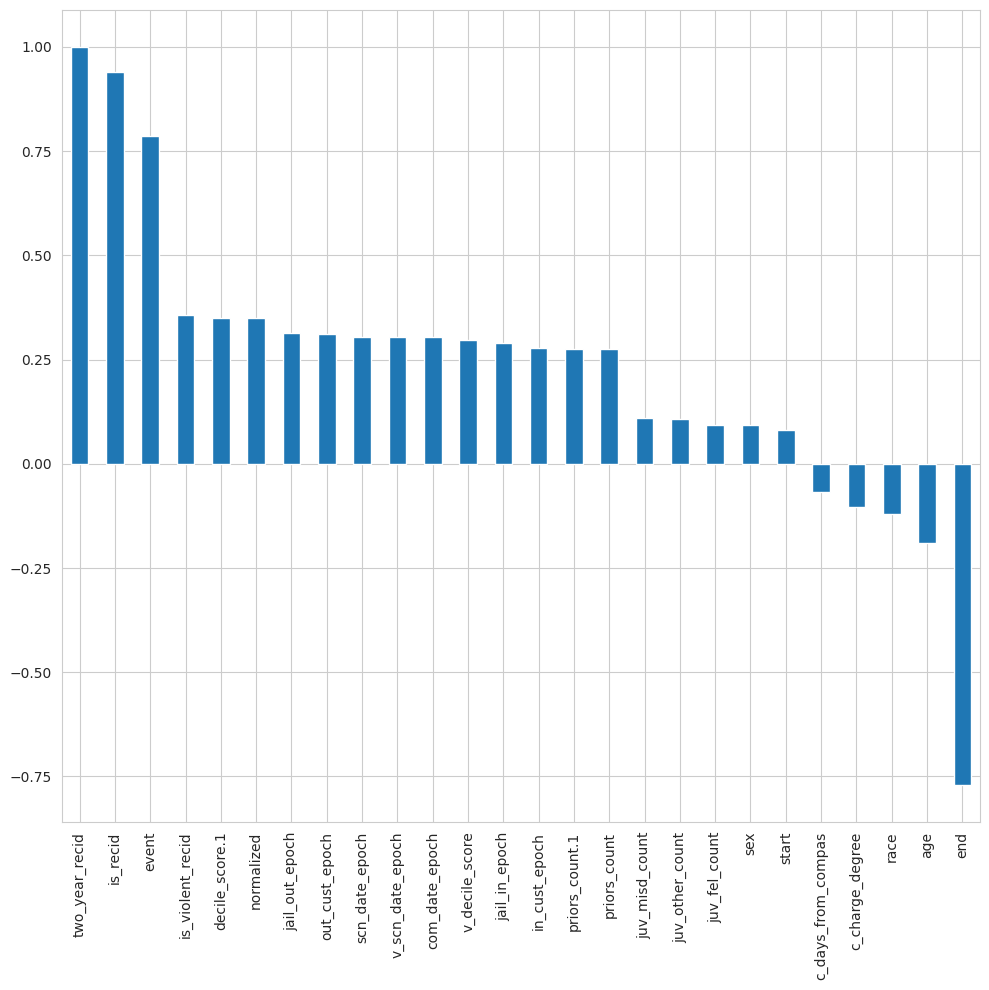

In [38]:
corrmap = compas_df.corr(numeric_only=True)
plt.figure(figsize=(10,10))
corrmap['two_year_recid'].sort_values(ascending=False).plot(kind='bar')

From the correlation plot above, the `juv_misd_count`, `juv_other_count`, `juv_fel_count`, `c_days_from_compas`, `sex`, and `start` features can safely be removed since they are not highly correlated with `two_year_recid`.  I will drop these.

In [39]:
drop_cols = ['is_recid','event','juv_misd_count','juv_other_count','juv_fel_count',
             'c_days_from_compas','sex','start']
compas_df.drop(columns=drop_cols, axis=1, inplace=True, errors='ignore')
compas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               7214 non-null   float64
 1   priors_count      7214 non-null   float64
 2   is_violent_recid  7214 non-null   float64
 3   decile_score.1    7214 non-null   float64
 4   v_decile_score    7214 non-null   float64
 5   priors_count.1    7214 non-null   float64
 6   end               7214 non-null   float64
 7   two_year_recid    7214 non-null   float64
 8   race              7214 non-null   int64  
 9   c_charge_degree   7214 non-null   int64  
 10  normalized        7214 non-null   float64
 11  jail_in_epoch     7214 non-null   int64  
 12  jail_out_epoch    7214 non-null   int64  
 13  in_cust_epoch     7214 non-null   int64  
 14  out_cust_epoch    7214 non-null   int64  
 15  scn_date_epoch    7214 non-null   int64  
 16  com_date_epoch    7214 non-null   int64  


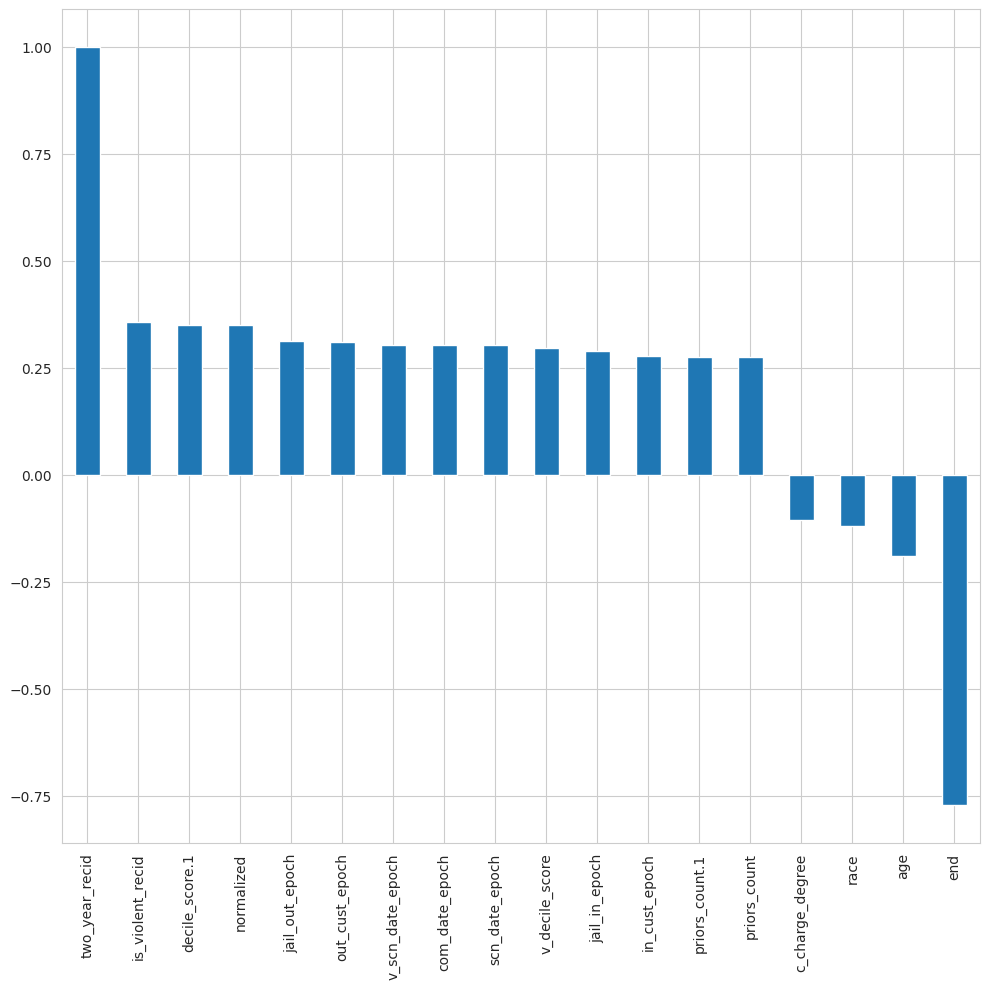

In [40]:
corrmap = compas_df.corr(numeric_only=True)
plt.figure(figsize=(10,10))
corrmap['two_year_recid'].sort_values(ascending=False).plot(kind='bar')
plt.savefig('figures/finalCorrMap.png', bbox_inches='tight', dpi=300)

### Create Training and Test Datasets

In [41]:
X = compas_df.drop('two_year_recid', axis=1)
y = compas_df['two_year_recid']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

### Scale Numeric Features
I will keep a copy of the original *X_train* and *X_test* datasets for training the Random Forest Classifier model.  It does not require scaled data

In [42]:
# Create scaler object
scaler = StandardScaler()

# Scale numeric values
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.fit_transform(X_test)

### Create and Train Logistic Regression Model

In [43]:
# Create model object
lr_model = LogisticRegression()

# Train and evaluate model
lr_report, lr_cm = score_model(lr_model, X_train_scaled, X_test_scaled, y_train, y_test)

Model:          LogisticRegression()
              precision    recall  f1-score   support

         0.0       0.93      0.87      0.90       823
         1.0       0.84      0.92      0.88       620

    accuracy                           0.89      1443
   macro avg       0.89      0.89      0.89      1443
weighted avg       0.89      0.89      0.89      1443

Train Score:    0.88
Accuracy Score: 0.89
TPR Rate:       0.92
TNR Rate:       0.56
FPR Rate:       0.13
FNR Rate:       0.08


### Create and Train SVM Model

In [44]:
svm_model = svm.SVC(random_state=42, probability=True)
svm_preds, svm_cm = score_model(svm_model, X_train_scaled, X_test_scaled, y_train, y_test)

Model:          SVC(probability=True, random_state=42)
              precision    recall  f1-score   support

         0.0       0.97      0.84      0.90       823
         1.0       0.82      0.96      0.88       620

    accuracy                           0.89      1443
   macro avg       0.89      0.90      0.89      1443
weighted avg       0.90      0.89      0.89      1443

Train Score:    0.90
Accuracy Score: 0.89
TPR Rate:       0.96
TNR Rate:       0.54
FPR Rate:       0.16
FNR Rate:       0.04


### Create and Train Random Forest Classifier

In [45]:
rfc_model = RandomForestClassifier(random_state=42, n_jobs=-1)
rfc_preds, rfc_cm = score_model(rfc_model, X_train, X_test, y_train, y_test)

Model:          RandomForestClassifier(n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

         0.0       0.96      0.87      0.91       823
         1.0       0.85      0.95      0.90       620

    accuracy                           0.91      1443
   macro avg       0.90      0.91      0.91      1443
weighted avg       0.91      0.91      0.91      1443

Train Score:    1.00
Accuracy Score: 0.91
TPR Rate:       0.95
TNR Rate:       0.55
FPR Rate:       0.13
FNR Rate:       0.05


### Training Score is Concerning
The training score for this model is 1.0 which might indicate it is overfitted.  This is most likely caused by noise in the data and one method to reduce the noise is to reduce the number of trees used by the model by setting the `n_estimators` hyperparameter.  The default is 100, so I will try a lower number.

In [46]:
reduced_rfc = RandomForestClassifier(random_state=42, n_estimators=2, n_jobs=-1)
reduced_preds, reduced_cm = score_model(reduced_rfc, X_train, X_test, y_train, y_test)

Model:          RandomForestClassifier(n_estimators=2, n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

         0.0       0.82      0.93      0.88       823
         1.0       0.89      0.73      0.81       620

    accuracy                           0.85      1443
   macro avg       0.86      0.83      0.84      1443
weighted avg       0.85      0.85      0.85      1443

Train Score:    0.95
Accuracy Score: 0.85
TPR Rate:       0.73
TNR Rate:       0.63
FPR Rate:       0.07
FNR Rate:       0.27


Reduced the number of estimators to two, but the model is still slightly overfitted.  I will use `GridSearchCV()` to find the optimal hyperparameter settings.

In [47]:
params = {'n_estimators': [2, 50],
          'max_features': ['auto', 'sqrt', 'log2'],
          'max_depth': [2, 3, 4, 5, 6],
          'min_samples_split': [2, 5, 10],
          'min_samples_leaf': [1, 5, 10],
          'criterion': ['gini', 'entropy']
         }
cv_rfc = GridSearchCV(estimator=rfc_model, param_grid=params, cv=5)
cv_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [2, 50]})

In [48]:
# Print the best hyperparameters
cv_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

In [49]:
# Give the new hyperparameters a try
tuned_rfc = RandomForestClassifier(criterion='gini', max_depth=5, max_features='sqrt',
                                   min_samples_leaf=1, min_samples_split=5, n_estimators=50, n_jobs=-1,
                                   random_state=42)
tuned_preds, tuned_cm = score_model(tuned_rfc, X_train, X_test, y_train, y_test)

Model:          RandomForestClassifier(max_depth=5, min_samples_split=5, n_estimators=50,
                       n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

         0.0       0.99      0.82      0.90       823
         1.0       0.80      0.99      0.89       620

    accuracy                           0.89      1443
   macro avg       0.90      0.90      0.89      1443
weighted avg       0.91      0.89      0.89      1443

Train Score:    0.91
Accuracy Score: 0.89
TPR Rate:       0.99
TNR Rate:       0.52
FPR Rate:       0.18
FNR Rate:       0.01


**NOTE**&nbsp;&nbsp;Not much improvement over the original model, but since I made an effort at hyperparameter tuning, I will use the parameters going forward

### Perform KFold Cross Validation

In [50]:
models = []
models.append(('LRG', LogisticRegression(random_state=42)))
models.append(('SVM', svm.SVC(random_state=42, probability=True)))
models.append(('RFC', RandomForestClassifier(criterion='entropy', max_depth=5, max_features='sqrt',
                                             n_estimators=50, random_state=42)))

seed = 42
num_folds = 5
scoring = 'neg_mean_squared_error'

results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

LRG: -0.296990 (0.121847)
SVM: -0.296833 (0.014517)
RFC: -0.101370 (0.007385)


**Visualize KFold Results**

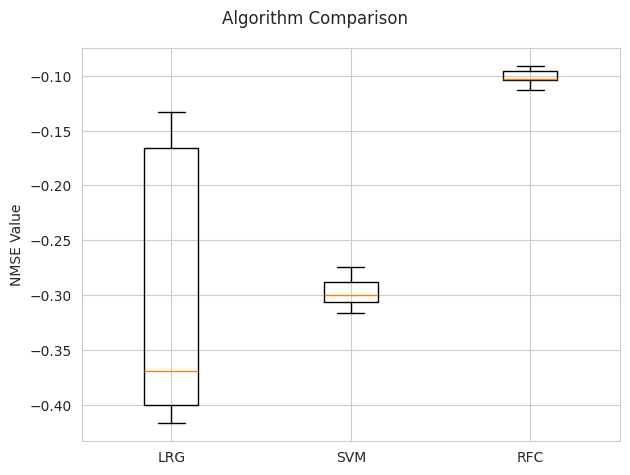

In [51]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.ylabel('NMSE Value')
pyplot.savefig('figures/boxplotAlgorithmComparison.png', bbox_inches='tight', dpi=300)
pyplot.show()

Appears the Random Forest Classifier (RFC) model has the NMSE score closest to zero.  Visualize how well its predictions matched the true values

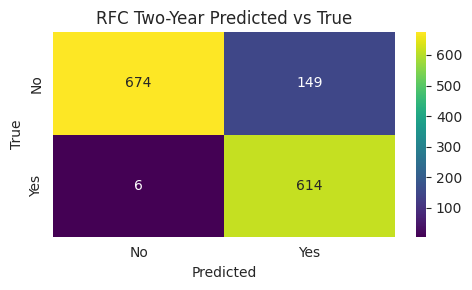

In [52]:
labels = ['No','Yes']
plt.figure(figsize=(5,3))
sns.heatmap(tuned_cm, annot=True, fmt='d', cmap='viridis', xticklabels=labels,
            yticklabels=labels)
plt.title('RFC Two-Year Predicted vs True')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('figures/cmTwoYearRFC.png', bbox_inches='tight', dpi=300)
plt.show()

The RFC model obtained an accuracy of around 99%.  I will calculate the *True Positive Rate (TPR)* and *False Positive Rates (FPR)* this should give a good idea how well the model is at predicting whether a defendant re-offends within two years

In [53]:
tpr, tnr, fpr, fnr = calc_rates(tuned_cm)
print(f'The SVM TPR rate is: {tpr:.2f}')
print(f'The SVM TNR rate is: {tnr:.2f}')
print(f'The SVM FPR rate is: {fpr:.2f}')
print(f'The SVM FNR rate is: {fnr:.2f}')

The SVM TPR rate is: 0.99
The SVM TNR rate is: 0.52
The SVM FPR rate is: 0.18
The SVM FNR rate is: 0.01


Since the *FPR* is relatively low, I will accept a *TPR* of 100%.  The *FPR* of 0.01 could be a rounding error. The *TNR* is 57% so the model is not very good at identifying true negatives. 

### Plot ROC Curve for RFC Model

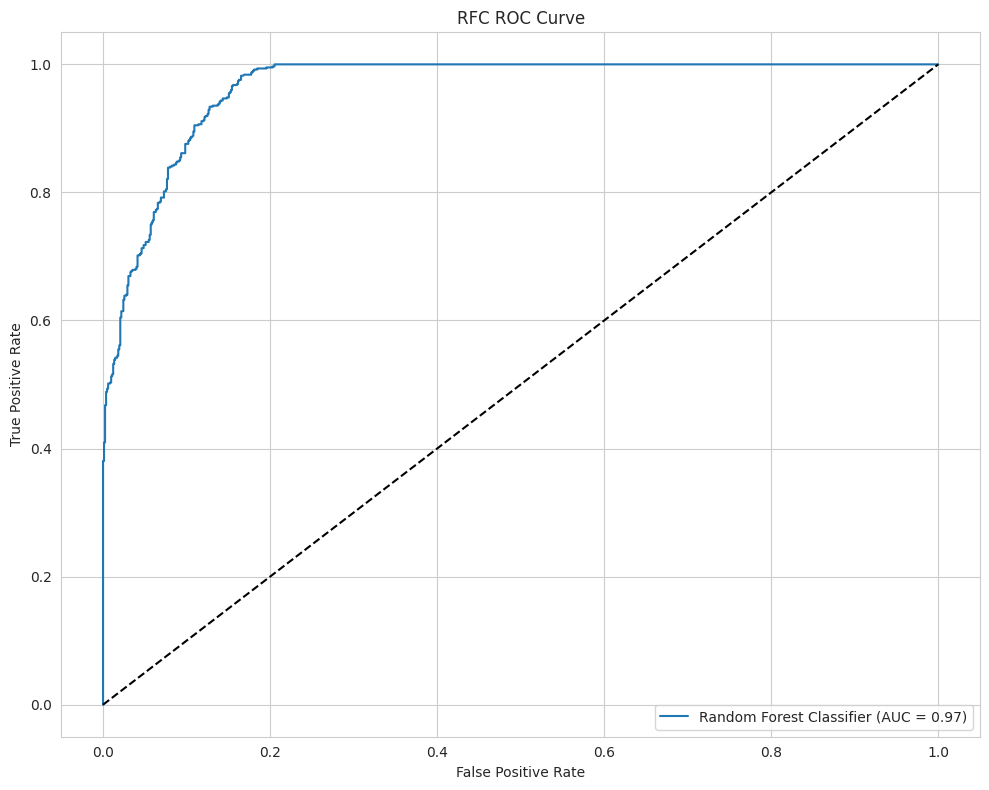

Optimal threshold: 0.54


In [54]:
rfc_probs = tuned_rfc.predict_proba(X_test)[:, 1]
rfc_auc = roc_auc_score(y_test, rfc_probs)
fpr, tpr, thresholds = roc_curve(y_test, rfc_probs)

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(fpr, tpr, label=f'Random Forest Classifier (AUC = {rfc_auc:.2f})')
plt.plot([0,1],[0,1], 'k--')
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate', title='RFC ROC Curve')
plt.legend(loc='lower right')
fig.savefig('figures/rocCurve.png', bbox_inches='tight', dpi=300)
plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f'Optimal threshold: {optimal_threshold:.2f}')